In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import ode

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Const
from sklearn.gaussian_process.kernels import DotProduct, RationalQuadratic as ratQuad

np.random.seed(1)


# Gaussian Process Regression

In this notebook we'll explore the use of Gaussian Processess to perform non-parametric regression of (mostly) non-linear data.  We're going to build on the data model wherein we used a recurrent NN to predict tracking data from a particle's path in a magnetic field.

In [2]:
# First we define the derivative using Newtonian motion
def newton(t, Y, q, m, B):
    """Computes the derivative of the state vector y according to the equation of motion:
    Y is the state vector (x, y, z, u, v, w) === (position, velocity).
    returns dY/dt.
    """
    x, y, z = Y[0], Y[1], Y[2]
    u, v, w = Y[3], Y[4], Y[5]
    
    alpha = q / m * B
    return np.array([u, v, w, 0, alpha * w, -alpha * v])

Training data shape:  (46, 3)
Target data shape:  (4, 3)


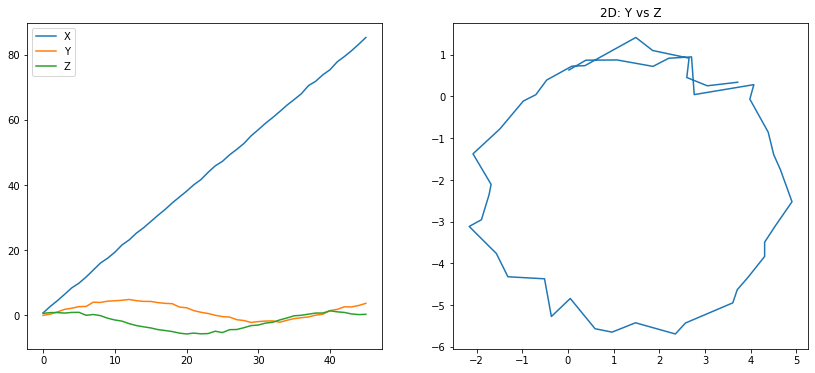

In [3]:
# Next we'll ste up our ODE integrator
r = ode(newton).set_integrator('dopri5')

# These variables will control our overall state for the problem.
# - Increase time steps to put more distance between points
# - Increase variance to add more noise to the path
# - Adjust the number of past steps to see how the RNN deals with longer or shorter sequences
variance = 0.2
time_step = 0.5
n_past = 46
n_future = 4

# Set initial position and velocity conditions
def getInitialConditions(seed):
    np.random.seed(seed)
    x0 = np.array(np.random.rand(3))
    v0 = np.array([np.random.rand()*5, np.random.rand()*2, np.random.rand()*2])
    return np.concatenate((x0, v0))

# Generate a trajectory sequence in 3D space
def getTrajectory(ode, q=1.0, m=3.0, b=1.0, dt=0.05, noise=0, nPred=4, nPast=100,seed=10):
    t0 = 0

    ode.set_initial_value(getInitialConditions(seed), t0).set_f_params(q,m,b)

    oPos = []
    oPos.append(ode.y[:3])
    while r.successful() and len(oPos) < nPred+nPast:
        r.integrate(ode.t+dt)
        var = np.random.randn(3)*noise
        oPos.append(ode.y[:3]+var) # keeping only position, not velocity

    ln = len(oPos)

    return np.array(oPos[:ln-nPred]), np.array(oPos[ln-nPred:ln])

# Let's grab one trajectory just to see what we got
posTrain, posTarget = getTrajectory(r, dt=time_step, noise=variance, nPred=n_future, nPast = n_past)

# And get the true values with zero noise
posTest, targetTest = getTrajectory(r, dt=time_step, noise=0, nPred=n_future, nPast = n_past+20)



print("Training data shape: ", posTrain.shape)
print("Target data shape: ", posTarget.shape)

# Make some plots to visualize things
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(posTrain[:, 0],label="X")
ax[0].plot(posTrain[:, 1],label="Y")
ax[0].plot(posTrain[:, 2],label="Z")
ax[0].legend()
ax[1].plot(posTrain[:, 1], posTrain[:, 2])
ax[1].set_title("2D: Y vs Z")
plt.show()

***
***
# Now let's build our Gaussian Processes model

Now that we've got data, let's try to fit it using a Gaussian Processes model.  We can try several different kernels to try to fit the data:

1. Constant: effectively an offset for the function, which can act as a mean value;
2. Radial basis function: specified by variance and length scale, creates smoothly varying functions;
3. Dot product: Dot product between data points, yields a linear relationship;
4. Rational quadratic: This an be viewed as a scale mixture (an infinite sum) of RBF kernels with different characteristic length-scales.

Each of these kernels has a different role, so we should see varying degrees of a "good fit" depending on our choices.

0.0316**2 + RBF(length_scale=14.9) + RationalQuadratic(alpha=1e+05, length_scale=14.9) + DotProduct(sigma_0=0.000383)


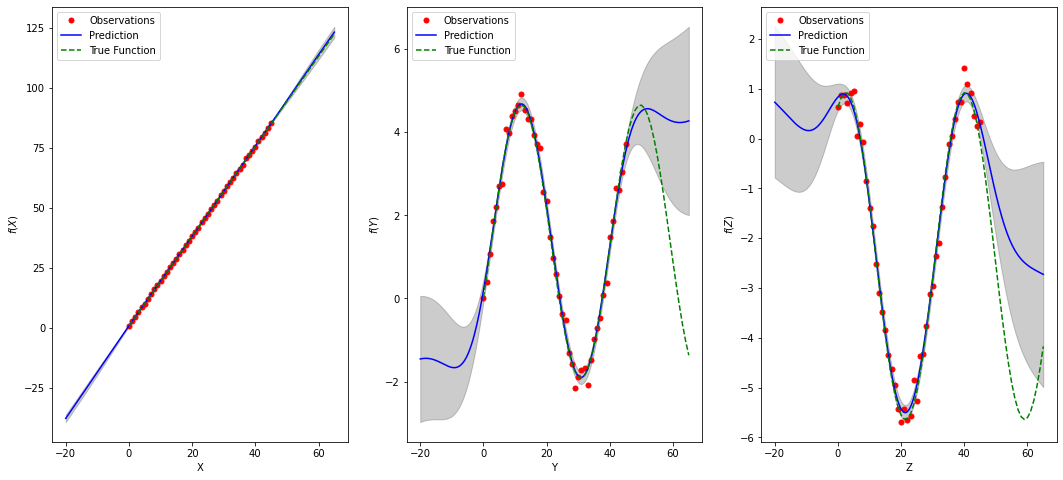

In [4]:
# ----------------------------------------------------------------------
X = np.zeros((n_past,3))
X[:,0] = np.arange(n_past)
X[:,1] = X[:,0]
X[:,2] = X[:,0]

X2 = np.zeros(posTest.shape)
X2[:,0] = np.arange(posTest.shape[0])
X2[:,1] = X2[:,0]
X2[:,2] = X2[:,0]

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
bins = 200
X_pred = np.zeros((bins,3))
X_pred[:,0] = np.linspace(X[0,0]-20,X[-1,0]+20,bins)
X_pred[:,1] = np.linspace(X[0,1]-20,X[-1,1]+20,bins)
X_pred[:,2] = np.linspace(X[0,2]-20,X[-1,2]+20,bins)

# Instantiate a Gaussian Process model
kernel1 = Const(1.0, (1e-3, 1e3)) 
kernel2 = DotProduct()
kernel3 = RBF(5, (1e-2, 20)) 
kernel4 = ratQuad() 
kernel5 = Const(1.0, (1e-3, 1e3)) + RBF(5, (1e-2, 20)) + DotProduct()
kernel6 = Const(1.0, (1e-3, 1e3)) + RBF(5, (1e-2, 20)) + ratQuad() + DotProduct()

gp = GaussianProcessRegressor(kernel=kernel6, alpha=variance, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, posTrain)

print(gp.kernel_)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X_pred, return_std=True)


# Plot the function, the prediction and the 95% confidence interval based on
# the MSE

vars = ('X','Y','Z')
fig, ax = plt.subplots(1,3,figsize=(18,8))
for idx in range(3):
    ax[idx].plot(X[:,idx], posTrain[:,idx], 'r.', markersize=10, label='Observations')
    ax[idx].plot(X_pred[:,idx], y_pred[:,idx], 'b-', label='Prediction')
    ax[idx].plot(X2[:,idx],posTest[:,idx],"g--",label="True Function")
    ax[idx].fill_between(X_pred[:,idx], y_pred[:,idx] - sigma, y_pred[:,idx] + sigma,
                     alpha=0.2, color='k')
    ax[idx].set_xlabel(vars[idx])
    ax[idx].set_ylabel(f'$f({vars[idx]})$')
    ax[idx].legend(loc='upper left')


# Next, let's try to predict future positions with GPs

We did this exercise with the recurrent NN approach and did a pretty good job of predicting the next 4 points in space after 46 past steps.  The RNN trained on random tracks, but the Gaussian Process approach will be a regression on each track.  Hopefully we do nearly as well as the RNN!

In [5]:
nTrials = 200


X_pred = np.zeros((n_future,3))
X_pred[:,0] = np.arange(n_past+1,n_past+n_future+1,1)
X_pred[:,1] = X_pred[:,0]
X_pred[:,2] = X_pred[:,0]

ratios = np.zeros((nTrials,n_future,3))


#for trial in range(nTrials):
trial = 0
while trial < nTrials:
    aseed = int(np.random.rand()*200000)
    
    aTrain, aTarget = getTrajectory(r, dt=time_step, noise=variance, nPred=n_future, nPast = n_past, seed = aseed)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    try:
        gp.fit(X, aTrain)
    except:
        print("An exception occurred!!")
        continue

    if trial % 20 == 0:
        print(f"Iteration {trial}/{nTrials}")

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred = gp.predict(X_pred)
    
    ratios[trial] = y_pred / aTarget
    trial += 1
    
print(ratios)

Iteration 0/200
Iteration 20/200
An exception occurred!!
Iteration 40/200
Iteration 60/200
Iteration 80/200
Iteration 100/200
Iteration 120/200
Iteration 140/200
An exception occurred!!
An exception occurred!!
Iteration 160/200
An exception occurred!!
Iteration 180/200
[[[ 1.00608476  1.06261367  1.19972936]
  [ 0.99458555  0.95600255  1.07409926]
  [ 1.01231648  0.83409743  1.20841506]
  [ 1.0168758   0.86199513  1.22449829]]

 [[ 1.01869403  0.95438314  1.00283279]
  [ 1.00594146  0.92232361  1.52400483]
  [ 1.01536843  0.96693855  1.83482742]
  [ 1.00648848  0.91219313  3.12572371]]

 [[ 1.01050687  1.01114132  1.03981423]
  [ 1.00973546  0.97807591  1.74828057]
  [ 1.0296783   0.87793162 43.54817912]
  [ 1.02118396  0.91228405 -0.61741849]]

 ...

 [[ 1.02411597  0.87863139  0.88926888]
  [ 1.02138719  0.95700212  1.17558666]
  [ 1.02654459  2.61856774  1.09398806]
  [ 1.02414192  0.9765482   1.20668586]]

 [[ 1.02245557  0.98338657  0.91699468]
  [ 1.21562598  0.98001826  0.932660

# And now the plots!

We'll calculate the min/max and mean/standard deviation for each dimension and for each of the future steps.  Our expectation should be that:

1. The Gaussian Process regression should do best for the first step and worst for the fourth step.  
2. The x-dimension is basically linear, so that should be well-modeled by the dot product kernel.
3. The y- and z-dimensions are sinusoidal, so they will be more tricky to get right.

Let's see!



Min / Max, Layer 0/X:  0.6747752057543288 1.3101240772349005
Min / Max, Layer 0/Y:  0.7874664752139285 1.5947948252606066
Min / Max, Layer 0/Z:  -5.509748406204953 15.035727438865436


Min / Max, Layer 1/X:  0.7757035537043605 1.3633762560410227
Min / Max, Layer 1/Y:  0.8168726054525335 1.3330485280478186
Min / Max, Layer 1/Z:  -1.768230070077545 14.863257937132177


Min / Max, Layer 2/X:  0.7492368207664657 1.1610176570758188
Min / Max, Layer 2/Y:  0.7927377782124794 2.6185677435580255
Min / Max, Layer 2/Z:  -22.484304466559212 43.548179120000015


Min / Max, Layer 3/X:  0.7229095251701003 1.4055169895147772
Min / Max, Layer 3/Y:  0.7666744700354851 2.331287778465023
Min / Max, Layer 3/Z:  -54.24936015479207 18.95691519668985





Mean / StdDev, Layer 0/X:  1.023242787682746 0.0376550378991139
Mean / StdDev, Layer 0/Y:  1.0102590516904923 0.08211071171079194
Mean / StdDev, Layer 0/Z:  1.0327865817638235 1.2909897318466783


Mean / StdDev, Layer 1/X:  1.0251042135370891 0.03874648777

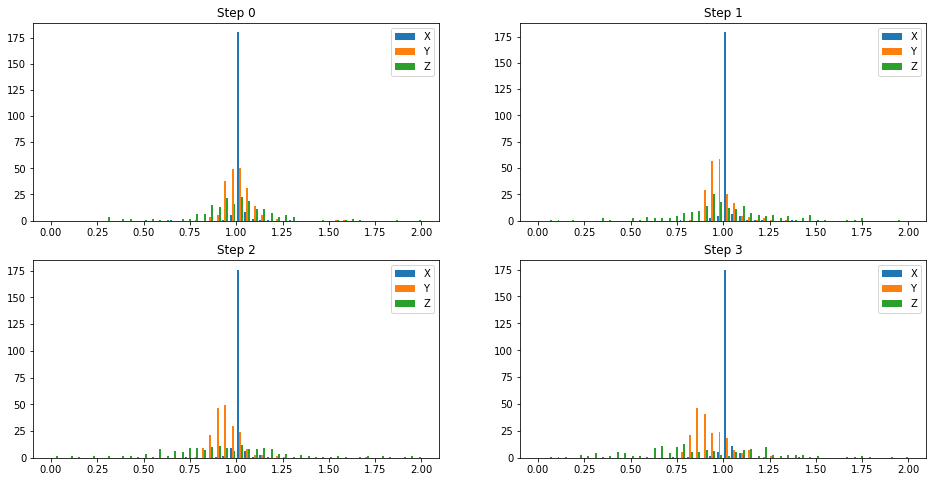

In [8]:
## More plots and statistics
xmin = 0
xmax = 2

for ix in range(ratios.shape[1]):
    print("\n")
    for iy in range(ratios.shape[2]):
        print(f"Min / Max, Layer {ix}/{vars[iy]}: ",np.min(ratios[:,ix,iy]), np.max(ratios[:,ix,iy]))

print("\n\n")
        
for ix in range(ratios.shape[1]):
    print("\n")
    for iy in range(ratios.shape[2]):
        print(f"Mean / StdDev, Layer {ix}/{vars[iy]}: ",np.mean(ratios[:,ix,iy]), np.std(ratios[:,ix,iy]))


fig, ax = plt.subplots(2,2,figsize=(16,8))
for ix in range(2):
    for iy in range(2):
        ax[ix,iy].hist(ratios[:,2*ix+iy],bins=50,range=(xmin,xmax),label=vars)
        ax[ix,iy].legend()
        ax[ix,iy].set_title(f"Step {2*ix+iy}")

plt.show()